# Modeling and Prediction

In [ ]:
import pandas as pd

# load preprocessed data
data = pd.read_csv('../data/cleaned_data.csv')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# define the observation and prediction windows
last_date = data['InvoiceDate'].max()
cutoff_date = last_date - pd.DateOffset(months=1)

# split data: features are built from data before the cutoff
features_data = data[data['InvoiceDate'] < cutoff_date]
target_data = data[data['InvoiceDate'] >= cutoff_date]

# identify customers who were active in the prediction month
active_in_last_month = target_data['CustomerID'].unique()

## 1. Target Variable Definition & Class Balance

**Analytical Context:** Before training the model, we must examine the distribution of our target variable (Churn).

- Class 1 (Churn): ~65.2%
- Class 0 (Active): ~34.8%

**Technical Insight:** The dataset exhibits a moderate class imbalance. While not extreme, this distribution informs our choice of evaluation metrics—shifting focus from simple Accuracy to Precision, Recall, and AUC-ROC—and justifies the use of cost-sensitive learning (e.g., class_weight='balanced') during model training.

In [ ]:
# set a snapshot date for recency calculation
snapshot_features = cutoff_date + pd.Timedelta(days=1)

# aggregate base RFM metrics
features = features_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_features - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                       # Frequency
    'TotalPrice': 'sum'                                           # Monetary
})

features.columns = ['Recency', 'Frequency', 'Monetary']

# engineer behavioral features
features['AvgBasketValue'] = features['Monetary'] / features['Frequency']
# calculate return rate (ratio of return transactions to total orders)
returns_count = features_data[features_data['Quantity'] < 0].groupby('CustomerID')['InvoiceNo'].nunique()
features['ReturnRate'] = (returns_count / features['Frequency']).fillna(0)

# product diversity metric
features['UniqueProducts'] = features_data.groupby('CustomerID')['StockCode'].nunique()

# binary encoding for geographic location
country_uk = features_data.groupby('CustomerID')['Country'].first().apply(lambda x: 1 if x == 'United Kingdom' else 0)
features['IsUK'] = country_uk

# define target: churn => 1 (not active in the last month), active => 0
features['Churn'] = features.index.isin(active_in_last_month).astype(int)
features['Churn'] = features['Churn'].apply(lambda x: 0 if x == 1 else 1)

print(features['Churn'].value_counts(normalize=True))

Churn
1    0.651855
0    0.348145
Name: proportion, dtype: float64


## 2. Machine Learning Pipeline & Model Training

**Technical Workflow:** We implement a robust experimental setup using a Random Forest Classifier. To ensure the model generalizes well to unseen data, we utilize a triple split:
- Training Set (60%): Used for model learning.
- Validation Set (20%): Used for hyperparameter tuning and early performance checks (AUC on val: 0.7328).
- Test Set (20%): Used for final, unbiased evaluation.

**Hyperparameter Strategy:** We constrained the model with max_depth=5 and n_estimators=50 to prevent overfitting, ensuring the logic remains simple enough to capture global patterns rather than noise.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# separate predictors and target variable
X = features.drop('Churn', axis=1)
y = features['Churn']

# initial split to isolate test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
# second split to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Set sizes: trening: {len(X_train)}, validation: {len(X_val)}, test: {len(X_test)}")

# initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    class_weight='balanced_subsample'
)

rf_model.fit(X_train, y_train)

# preliminary performance check on validation data
val_probs = rf_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"AUC on validation set: {val_auc:.4f}")

Set sizes: trening: 2457, validation: 819, test: 820
AUC on validation set: 0.7328


## 3. Model Performance Evaluation

**Model Diagnostics:**
- ROC-AUC Score (0.76): The model demonstrates good discriminative power, significantly outperforming a random classifier (0.50).
- Recall for Churn (0.76): This is our most critical metric. It indicates that the model successfully captures 76% of all actual churners, allowing the business to intervene before they leave.
- F1-Score (0.77): The harmonic mean of precision and recall shows a strong, balanced performance for the minority class (active customers).

In [ ]:
# final predictions on unseen test data
y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# comprehensive classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       285
           1       0.79      0.76      0.77       535

    accuracy                           0.71       820
   macro avg       0.68      0.68      0.68       820
weighted avg       0.71      0.71      0.71       820



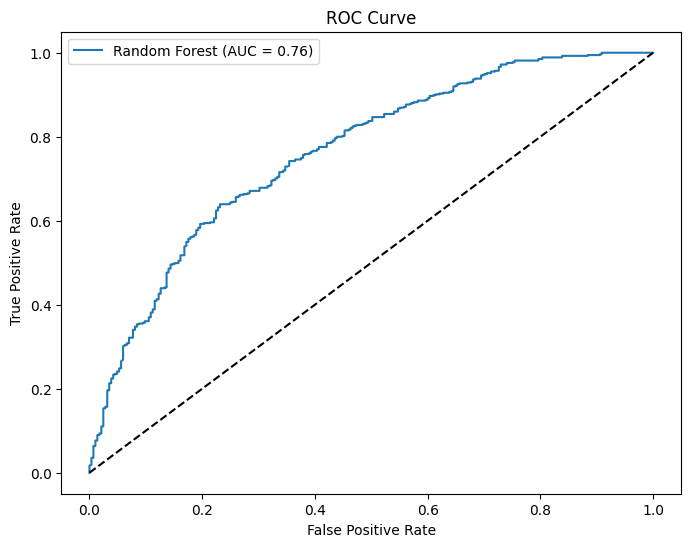

In [ ]:
# plot ROC Curve to visualize sensitivity vs specificity
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 4. Error Analysis: Confusion Matrix

**Interpretation of Results:** The confusion matrix highlights the model's practical utility:
- True Positives (406): Correctly identified customers who were about to churn.
- False Alarms (111): Customers predicted to churn who actually remained active. In a business context, "over-marketing" to these customers is generally less costly than losing high-value churners (Type II error).

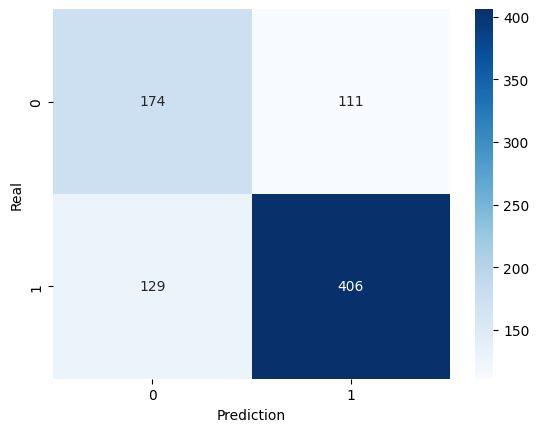

In [ ]:
# Confusion Matrix to evaluate true positives vs false alarms
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

## 5. Feature Importance: Understanding Churn Drivers

**Strategic Business Insights:** The Random Forest model identified the following key predictors of customer attrition:
- Frequency & Monetary: High-value, frequent shoppers are paradoxically at risk if their patterns shift, likely due to high expectations.
- Recency: As expected, the time elapsed since the last purchase remains a powerful signal of disengagement.
- UniqueProducts: Customers with a narrow product portfolio are more likely to churn than those who shop across multiple categories.
- IsUK: This feature has negligible importance (~0), suggesting that churn behavior is driven by engagement metrics rather than geographic location.


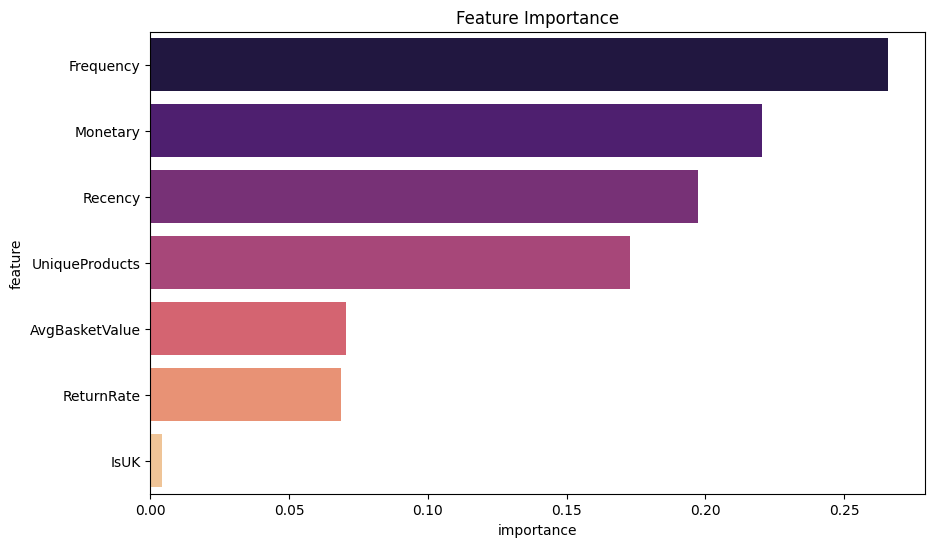

In [ ]:
# extract and visualize feature importance from the model
importances = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

# visualize global feature influence
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances, palette='magma', hue='feature', legend=False)
plt.title('Feature Importance')
plt.show()